In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from models import ConditionalDiscriminator, ConditionalGenerator
from torchsummary import summary
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader


import numpy as np

from tqdm import tqdm
import os
import shutil
from torch.utils.tensorboard import SummaryWriter

f:\Uni\Cuda-Lab\Cuda_Lab\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BSZ = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BSZ, shuffle=True, drop_last=True)

In [6]:
if not os.path.exists("tboard_logs"):
    os.mkdir("tboard_logs")
writer = SummaryWriter(log_dir="tboard_logs/CGAN")

## 1. Conditional GANs

In [7]:
discriminator = ConditionalDiscriminator(784, 1)
generator = ConditionalGenerator(128, 784)

optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))
optim_generator = torch.optim.Adam(generator.parameters(), lr=3e-4, betas=(0.5, 0.999))


discriminator.to(device)
generator.to(device)

criterion = nn.MSELoss()

for epoch in range(100):
    generator.train()
    discriminator.train()
    G_loss = []
    D_loss = []

    for batch, (images, labels) in tqdm(enumerate(train_loader)):
        random_noise = torch.rand(BSZ, 128, device=device)
        fake_labels = torch.randint(0,10, (BSZ, ), device=device)
        generated_images = generator(random_noise, fake_labels)

        images = images.view(-1, 784).to(device)

        labels = labels.to(device)

        true_labels = torch.ones(BSZ).to(device)

        optim_discriminator.zero_grad()

        discriminator_output_true_data = discriminator(images, labels)

        true_discriminator_loss = criterion(discriminator_output_true_data, true_labels)

        discriminator_output_for_generated_data = discriminator(generated_images.detach(), fake_labels).view(BSZ)

        generator_discriminator_loss = criterion(
            discriminator_output_for_generated_data, torch.zeros(BSZ).to(device)
        )

        discriminator_loss = (
            true_discriminator_loss + generator_discriminator_loss
        )

        discriminator_loss.backward()
        optim_discriminator.step()

        D_loss.append(discriminator_loss.item())



        optim_generator.zero_grad()

        generated_images = generator(random_noise, fake_labels)

        discriminator_output_generated_data = discriminator(generated_images, fake_labels).view(BSZ)

        generator_loss = criterion(discriminator_output_generated_data, true_labels)

        generator_loss.backward()
        optim_generator.step()

        G_loss.append(generator_loss.item())

    if (epoch+1) % 5 == 0:
        generator.eval()
        labels = torch.tensor([i % 10 for i in range(20)], device=device)
        random_noise = torch.rand(20, 128, device=device)
        images = generator(random_noise, labels).view(-1, 1, 28, 28)
        grid = torchvision.utils.make_grid(images, nrow=5)
        writer.add_image(f'images', grid, epoch+1)


    writer.add_scalar("CGAN/Generator Loss", np.mean(G_loss), epoch)
    writer.add_scalar("CGAN/Discriminator Loss", np.mean(D_loss), epoch)



    

0it [00:00, ?it/s]f:\Uni\Cuda-Lab\Cuda_Lab\venv\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
937it [00:18, 50.14it/s]
937it [00:16, 57.46it/s]
937it [00:16, 58.11it/s]
937it [00:16, 57.89it/s]
937it [00:16, 58.07it/s]
937it [00:16, 57.23it/s]
937it [00:16, 57.70it/s]
937it [00:16, 57.94it/s]
937it [00:16, 57.30it/s]
937it [00:16, 57.94it/s]
937it [00:16, 57.51it/s]
937it [00:16, 58.21it/s]
937it [00:16, 57.46it/s]
937it [00:16, 57.91it/s]
937it [00:16, 58.25it/s]
937it [00:15, 58.69it/s]
937it [00:15, 58.68it/s]
937it [00:16, 58.27it/s]
937it [00:16, 57.31it/s]
937it [00:16, 57.80it/s]
937it [00:16, 57.97it/s]
937it [00:16, 57.53it/s]
937it [00:16, 57.20it/s]
937it [00:16, 57.43it/s]
937it [00:16, 56.21it/s]
937i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


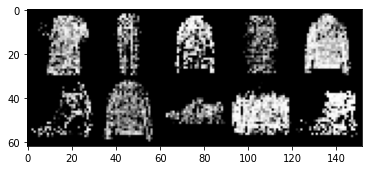

In [8]:
random_noise = torch.rand(10, 128, device=device)
fake_labels = torch.tensor([i for i in range(10)], device=device)

images = generator(random_noise, fake_labels).view(-1, 1, 28, 28)
grid = torchvision.utils.make_grid(images, nrow=5)

import matplotlib.pyplot as plt

plt.imshow(grid.cpu().permute(1, 2, 0))


You can definetely recognize some of the fashion pieces and it is quite cool, that we can decide which piece to generate with the class label. But our model tends to forget stuff it has already learned. For example the bag and the last boot looked much better a few episodes before, as you can see in Tensorflow.

## 2. Deep Convolutional GANs

In [9]:
from DCGAN import DCGenerator, DCDiscriminator

In [10]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

#We used a smaller version of the dataset because we miscalculated the training time a bit
train_dataset = datasets.CelebA(root="data/", split="train", transform=data_transforms['train'], download=True)
#train_dataset, subtrain_dataset =  torch.utils.data.random_split(train_dataset, [9984, len(train_dataset) - 9984]) 
# test_dataset = datasets.CelebA(root="data/", split="test", transform=data_transforms['test'], download=True)
# test_dataset, subtrain_dataset =  torch.utils.data.random_split(test_dataset, [1000, len(test_dataset) - 1000]) 
train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True, drop_last=True)

Files already downloaded and verified


In [11]:
dc_generator = DCGenerator()
print(dc_generator)

DCGenerator(
  (conv1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)


In [12]:
dc_discriminator = DCDiscriminator()
print(dc_discriminator)

DCDiscriminator(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)


In [13]:
def image_to_vector(img):
    """ Converting images into vectors """
    vector = img.view(img.shape[0], -1)
    return vector 

def vector_to_image(vector, shape=(3,64,64)):
    """ Converting flattened images into matrices """
    images = vector.view(vector.shape[0], *shape)
    return images

In [14]:
class Trainer:
    def __init__(self, generator, discriminator, device, latent_dim, writer=None):
        assert writer is not None, f"Tensorboard writer not set..."
        self.latent_dim = latent_dim
        self.writer = writer
        self.device = device
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        self.optim_DCdiscriminator = torch.optim.Adam(dc_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.optim_DCgenerator = torch.optim.Adam(dc_generator.parameters(), lr=2e-3, betas=(0.5, 0.999))
        self.criterion = nn.MSELoss()
        
    def train_one_step(self, imgs):
        self.generator.train()
        self.discriminator.train()

        ##################################
        # ==== Training Discriminator ====
        ##################################
        
        self.optim_DCdiscriminator.zero_grad()
        prediction_real = self.discriminator(imgs)        
        
        d_loss_real = self.criterion(prediction_real, torch.ones((BSZ,1), device=device))
        
        # Generating fake samples with the generator
        fake_samples = self.generator(torch.randn(BSZ, self.latent_dim).to(device))
        prediction_fake = self.discriminator(fake_samples.detach())
        
        d_loss_fake = self.criterion(prediction_fake, torch.zeros((BSZ,1), device=device))
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_DCdiscriminator.step()
        
        #############################
        # === Train the generator ===
        #############################
        self.optim_DCgenerator.zero_grad()
        prediction_fake_g = self.discriminator(fake_samples)
        g_loss = self.criterion(prediction_fake_g, torch.ones((BSZ,1), device=device))
        g_loss.backward()
        self.optim_DCgenerator.step()
        return d_loss, g_loss

    @torch.no_grad()
    def generate(self, BSZ=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(BSZ, self.latent_dim).to(device)
        samples = self.generator(latent)
        imgs = vector_to_image(samples)
        imgs = imgs * 0.5 + 0.5
        return imgs
    
    def train(self, data_loader, N_iters=10, init_step=0):
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in range(N_iters):
            for real_batch, _ in data_loader:           
                #real_samples = image_to_vector(real_batch)
                #real_samples = real_samples.to(self.device)
                real_samples = real_batch.to(self.device)
                d_loss, g_loss = self.train_one_step(imgs=real_samples)
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item()
                        }, iter_)    
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [15]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if os.path.exists("imgs/training"):  
    shutil.rmtree("imgs/training")

if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

In [16]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "DCGAN")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [17]:
trainer = Trainer(generator=dc_generator, discriminator=dc_discriminator, device=device, latent_dim=100, writer=writer)

In [18]:
trainer.train(data_loader=train_loader)

Ep 4 Iter 8486: D_Loss=0.55923, G_Loss=0.98326):   0%|          | 0/10 [13:19<?, ?it/s]

KeyboardInterrupt: 

This is a very similar picture to the CGAN we saw earlier. Some of the epochs produce quite nice pictures of fake celebrities but sometimes the network seems to just go into a completely different direction with the gradient.

You can have a look ath the images in tensorboard.

### Wasserstein GANs

In [19]:
class discriminator_loss(nn.Module):
    
    def forward(self, real, fake):
        return - torch.mean(real.reshape(-1)) + torch.mean(fake.reshape(-1))

class generator_loss(nn.Module):
    
    def forward(self, fake):
        return - torch.mean(fake.reshape(-1))

In [20]:
dc_generator = DCGenerator()
dc_discriminator = DCDiscriminator()

In [21]:
class WTrainer:
    def __init__(self, generator, discriminator, device, latent_dim, writer=None):
        assert writer is not None, f"Tensorboard writer not set..."
        self.latent_dim = latent_dim
        self.writer = writer
        self.device = device
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        self.optim_DCdiscriminator = torch.optim.RMSprop(dc_discriminator.parameters(), lr=5e-5)
        self.optim_DCgenerator = torch.optim.RMSprop(dc_generator.parameters(), lr=5e-5)
        self.criterion_d = discriminator_loss()
        self.criterion_g = generator_loss()
        
        
    def train_one_step(self, imgs):
        self.generator.train()
        self.discriminator.train()

        ##################################
        # ==== Training Discriminator ====
        ##################################
        
        self.optim_DCdiscriminator.zero_grad()
        prediction_real = self.discriminator(imgs)        
        
        # Generating fake samples with the generator
        fake_samples = self.generator(torch.randn(BSZ, self.latent_dim).to(device))
        prediction_fake = self.discriminator(fake_samples.detach())
        
        d_loss = self.criterion_d(prediction_real, prediction_fake)
        d_loss.backward()
        
        self.optim_DCdiscriminator.step()
        #torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        
        for p in self.discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
        
        #############################
        # === Train the generator ===
        #############################
        self.optim_DCgenerator.zero_grad()
        prediction_fake_g = self.discriminator(fake_samples)
        g_loss = self.criterion_g(prediction_fake_g)
        g_loss.backward()
        self.optim_DCgenerator.step()
        return d_loss, g_loss

    @torch.no_grad()
    def generate(self, BSZ=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(BSZ, self.latent_dim).to(device)
        samples = self.generator(latent)
        imgs = vector_to_image(samples)
        imgs = imgs * 0.5 + 0.5
        return imgs
    
    def train(self, data_loader, N_iters=10, init_step=0):
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in range(N_iters):
            for real_batch, _ in data_loader:           
                #real_samples = image_to_vector(real_batch)
                #real_samples = real_samples.to(self.device)
                real_samples = real_batch.to(self.device)
                d_loss, g_loss = self.train_one_step(imgs=real_samples)
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item()
                        }, iter_)    
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training_w", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [22]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if os.path.exists("imgs/training_w"):  
    shutil.rmtree("imgs/training_w")
if not os.path.exists("imgs/training_w"):
    os.makedirs("imgs/training_w")


In [23]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "WassersteinGAN")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [24]:
trainer = WTrainer(generator=dc_generator, discriminator=dc_discriminator, device=device, latent_dim=100, writer=writer)

In [25]:
trainer.train(data_loader=train_loader)

KeyboardInterrupt: 

The WatersteinGan images only look okay in our eyes. They are to vibrant and lack detail to be close to real images.